In [1]:
import numpy as np
import scipy.io
from matplotlib import pyplot as plt

In [2]:
# define os - used for making paths
os = 'linux'
# os = 'windows'

# Open .mat file

In [3]:
# load input data
if os == 'linux':
    data_path = '../../data/original_files/'
elif os == 'windows':
    data_path = '../../data/'

input_data = scipy.io.loadmat(data_path + 'salamanderRGCdata_long_fish_movie.mat')

In [4]:
# some dictionary utility functions

def print_keys(dict):
    keys = list(dict.keys())
    nitems = len(dict.items())
    
    print("\nkeys = ")
    for i in range(nitems):
        print("\"{}\"".format(keys[i]))
        
def print_items(dict):
    items = list(dict.items())
    nitems = len(items)
    
    print("\nitems = ")
    for i in range(nitems):
        print("key #{} = {}".format(i, items[i][0]))
        print("value #{} = {}\n".format(i, items[i][1]))
        
def show_dict(dict):
    nitems = len(dict.items())

    print("type = {0}".format(type(dict)))
    print("number of items = {0}".format(nitems))
    print_keys(dict)
    print_items(dict)
    
    return nitems

In [5]:
# read input data
nitems = show_dict(input_data)

type = <class 'dict'>
number of items = 14

keys = 
"__header__"
"__version__"
"__globals__"
"frame_start_times"
"frames"
"ncells"
"ntrials"
"plot_example_frame"
"spike_times_by_trial"
"time_units"
"xpixels"
"ypixels"
"I_order"
"binned_data"

items = 
key #0 = __header__
value #0 = b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Sat Apr 23 21:05:09 2016'

key #1 = __version__
value #1 = 1.0

key #2 = __globals__
value #2 = []

key #3 = frame_start_times
value #3 = [[0.00000000e+00 1.66852491e+01 3.33704983e+01 ... 1.89878135e+04
  1.90044988e+04 1.90211840e+04]]

key #4 = frames
value #4 = [[[126 169 169 ... 117 111 114]
  [131 145 140 ... 106 108 111]
  [135 135 131 ... 108 114 114]
  ...
  [150 153 169 ... 124 131 134]
  [162 169 167 ... 118 123 135]
  [170 164 167 ... 111 127 133]]

 [[127 171 171 ... 115 111 113]
  [131 146 142 ... 105 106 113]
  [135 135 133 ... 109 114 114]
  ...
  [148 154 170 ... 124 130 134]
  [163 170 167 ... 120 122 135]
  [171 165 167 ... 113 125 133]]

## description of the file content

__The data is 297 repeats of a 19s long greyscale movie played at 60Hz. There are 113 total cells. The neuron spike data is binned so it's aligned with the movie frames.__

* __binned_data__: the neuron spike data organized in (number of trials x number of frames x number of cells)

* __frame_start_times__: the time (in ms) when each frame in the movie begins, aligned so the start of the first frame is at 0ms

* __frames__: the actual frames of the movie organized in (frame number x X x Y)

* __I_order__: the cells sorted by their single spike info in descending order. You should take the first 10 entries.

* __ncells__: the number of cells

* __ntrials__: the number of trials

* __plot_example_frame__: some MATLAB code to visualize a frame from the movie, saved as a string

* __spike_times_by_trial__: the exact time (in ms) each spike occurred during each stimulus presentation, for all cells. Organized in (cells x trials). The binned data is more useful for your purposes

### About I_order

I_order is calculated by the following formula:

I(cell; stimulus) = 1/T* sum(r(t)/rbar*(log2(r(t)/rbar))

where r(t) is the firing rate in each bin (calculated by taking the mean response over all repetitions), and rbar is the mean response over the entire movie. Both r(t) and rbar are calculated for a specific cell.

So I(cell; stimulus) is a measure of the information content of each cell's spikes during the movie.
Cells are sorted by their I(cell; stimulus) in decsending order which gives us I_order.

Justification for this equation can be found in Brenner et al 2000, linked below. 

https://www.princeton.edu/~wbialek/our_papers/brenner+al_00b.pdf

---
I will choose the first 10 cells in the I_order for the classification problem; because these cells are the most informative, their classification should have a more porminant explanation w.r.t. the movie.

# Explore the data

## movie

In [6]:
# make dictionary content more accessible
frames = input_data['frames']
binned_data = input_data['binned_data']
I_order = input_data['I_order'].reshape(-1)
ncells = int(input_data['ncells'])
ntrials = int(input_data['ntrials'])

# show basic sizes of datasets
print(ncells, 'cells are recorded.')
print(ntrials, 'repeats of the movie are played.')
print('frames are ordered in', frames.shape, 'shape.')
print('binned neuron spike data is ordered in', binned_data.shape, 'shape.')

113 cells are recorded.
297 repeats of the movie are played.
frames are ordered in (1141, 120, 200) shape.
binned neuron spike data is ordered in (297, 1141, 113) shape.


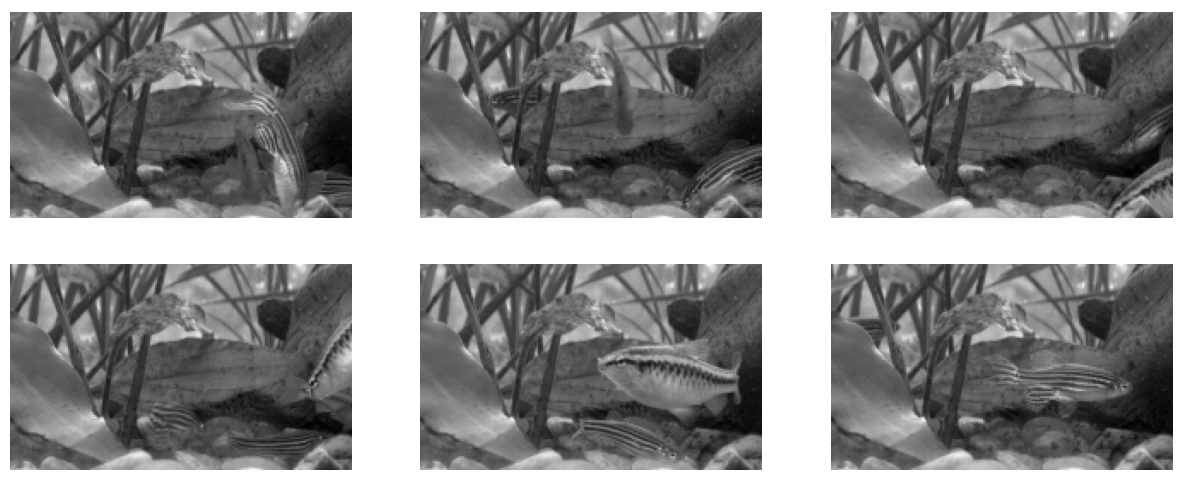

In [7]:
def show_random_frames(frames, nframes, seed=None):
    assert(len(frames) >= nframes)
    
    if seed is not None:
        np.random.seed(seed)
    
    plt.figure(figsize = (15, nframes))
    
    for i in range(nframes):
        ind = np.random.randint(0,len(frames))
        plt.subplot(-(nframes//-3),3,i+1)
        plt.imshow(frames[ind], cmap='gray')
        plt.axis("off")
        plt.axis("equal")

show_random_frames(frames, 6, seed=0)

## spikes

In [8]:
binned_data.shape

(297, 1141, 113)

In [9]:
trialids = np.array([0]) # which trials to show
# the following two variables define the specific shot of the trial to show
nframes2show = 1141
startframe = 0
cells2show = I_order[:10] # which cells to show
ntrials = trialids.shape[0]
ncells2show = cells2show.shape[0]

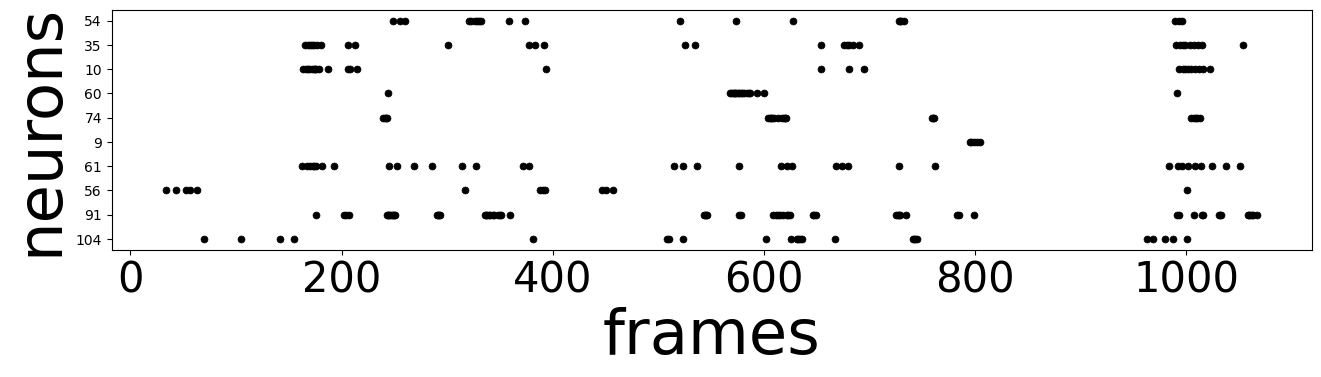

In [20]:
# plot defined spike graphs
x = np.arange(startframe, startframe+nframes2show)
X = np.broadcast_to(x[:, np.newaxis], (nframes2show, ncells2show))

y = np.arange(ncells2show, 0, -1).astype(float)
Y = np.outer(np.ones(nframes2show), y)

plt.figure(figsize = (15, ncells2show*ntrials//3))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

for i in range(ntrials):
    # select defined spike graphs
    z = binned_data[trialids[i], startframe:startframe+nframes2show, cells2show].astype(float)
    
    Z = Y.copy()
    Z[z.T == 0] = np.nan # only active neurons will be shown in the plot, any nonvisible neuron is inactive

    plt.subplot(ntrials, 1, i+1)
    _ = plt.plot(X, Z, marker='o', markersize=5, markeredgewidth=0.5, linestyle='', color='black')
    plt.tick_params(axis='x', which='major', labelsize=30)
    plt.yticks(y, cells2show)
    plt.xlabel('frames', fontsize = 45)
    plt.ylabel('neurons', fontsize = 45)
    # plt.title('trial #{}'.format(trialids[i]))

## save frames and spikes data in .csv file

In [25]:
# save frames and spikes in file
frames_reshaped = frames.reshape(frames.shape[0], -1)
np.savetxt(data_path + 'frames.csv', frames_reshaped, delimiter=',')

binned_data_reshaped = binned_data.reshape(binned_data.shape[0], -1)
np.savetxt(data_path + 'spikes.csv', binned_data_reshaped, delimiter=',')

### code snippet to load frames and spikes data from .csv file

In [25]:
del frames
frames = np.loadtxt(data_path + 'frames.csv', delimiter=',')
frames = frames.reshape(frames.shape[0], 120, 200)

del binned_data
binned_data = np.loadtxt(data_path + 'spikes.csv', delimiter=',')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)